# Lesson 6 - Schema Proposal for Structured Data

In this lesson, you will build an agent that can propose a knowledge graph schema.
The agent will analyze the approved import files and consider how to satisfy the approved user goal.

You'll learn:
- how to pair agents into a "critic pattern"
- how to use tools to focus an agent's thinking


<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>To access the helper.py, neo4j_for_adk.py and tools.py files :</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

</div>

## 6.1. Agent


<img src="images/entire_solution.png" width="500">

Multiple agents will collaborate to propose construction rules for a knowledge graph

- Input: `approved_user_goal`, `approved_files`
- Output: `approved_construction_plan`
- Tools: `get_approved_user_goal`, `get_approved_files`, `sample_file`, 
        `propose_node_construction`, `propose_relationship_construction`, 
        `get_proposed_construction_plan`,`approve_proposed_construction_plan`


**Workflow**


This workflow will use multiple agents to propose a construction plan for the knowledge graph.

A top-level 'schema_refinement_loop' will coordinate three agents operating in a loop:
1. A 'schema_proposal_agent' that proposes a schema and construction plan for the knowledge graph.
2. A 'schema_critic_agent' that critiques the proposed schema and construction plan for the knowledge graph.
3. A 'CheckStatusAndEscalate' agent that checks the feedback of the critic agent

## 6.2. Setup

The usual import of needed libraries, loading of environment variables, and connection to Neo4j.

In [90]:
# Import necessary libraries
import os
from pathlib import Path

from google.adk.agents import LlmAgent, LoopAgent
from google.adk.models.lite_llm import LiteLlm # For OpenAI support
from google.adk.tools import ToolContext

# For type hints
from typing import Dict, Any, List

# Convenience libraries for working with Neo4j inside of Google ADK
from neo4j_for_adk import graphdb, tool_success, tool_error

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.CRITICAL)

print("Libraries imported.")

Libraries imported.


In [91]:
# --- Define Model Constants for easier use ---
MODEL_GPT_4O = "openai/gpt-5-mini"

llm = LiteLlm(model=MODEL_GPT_4O)

# Test LLM with a direct call
print(llm.llm_client.completion(model=llm.model, messages=[{"role": "user", "content": "Are you ready?"}], tools=[]))

print("\nOpenAI ready.")

ModelResponse(id='chatcmpl-CwTKOPy6MAE90gvisEitQde0nc7WR', created=1768051796, model='gpt-5-mini-2025-08-07', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='stop', index=0, message=Message(content="Yes — I'm ready. How can I help you today?", role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[]), provider_specific_fields={})], usage=Usage(completion_tokens=21, prompt_tokens=107, total_tokens=128, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None)), service_tier='default')

OpenAI ready.


## 6.3. Agent Instructions for Schema Proposal

In [92]:
# Notice the use of {feedback} in the string.
# Google ADK will replace this from session context if it exists.
# Because feedback could be long, XML-like delimiters are included to clarify the content.
proposal_agent_role_and_goal = """
    You are an expert at knowledge graph modeling with property graphs. Propose an appropriate
    schema by specifying construction rules which transform approved files into nodes or relationships.
    The resulting schema should describe a knowledge graph based on the user goal.
    
    Consider feedback if it is available: 
    <feedback>
    {feedback}
    </feedback> 
"""

In [93]:
proposal_agent_hints = """
    Every file in the approved files list will become either a node or a relationship.
    Determining whether a file likely represents a node or a relationship is based
    on a hint from the filename (is it a single thing or two things) and the
    identifiers found within the file.

    Because unique identifiers are so important for determining the structure of the graph,
    always verify the uniqueness of suspected unique identifiers using the 'search_file' tool.

    General guidance for identifying a node or a relationship:
    - If the file name is singular and has only 1 unique identifier it is likely a node
    - If the file name is a combination of two things, it is likely a full relationship
    - If the file name sounds like a node, but there are multiple unique identifiers, that is likely a node with reference relationships

    Design rules for nodes:
    - Nodes will have unique identifiers. 
    - Nodes _may_ have identifiers that are used as reference relationships.

    Design rules for relationships:
    - Relationships appear in two ways: full relationships and reference relationships.

    Full relationships:
    - Full relationships appear in dedicated relationship files, often having a filename that references two entities
    - Full relationships typically have references to a source and destination node.
    - Full relationships _do not have_ unique identifiers, but instead have references to the primary keys of the source and destination nodes.
    - The absence of a single, unique identifier is a strong indicator that a file is a full relationship.
    
    Reference relationships:
    - Reference relationships appear as foreign key references in node files
    - Reference relationship foreign key column names often hint at the destination node and relationship type
    - References may be hierarchical container relationships, with terminology revealing parent-child, "has", "contains", membership, or similar relationship
    - References may be peer relationships, that is often a self-reference to a similar class of nodes. For example, "knows" or "see also"

    The resulting schema should be a connected graph, with no isolated components.
"""

In [94]:
proposal_agent_chain_of_thought_directions = """
    Prepare for the task:
    - get the user goal using the 'get_approved_user_goal' tool
    - get the list of approved files using the 'get_approved_files' tool
    - get the current construction plan using the 'get_proposed_construction_plan' tool

    Think carefully, using tools to perform actions and reconsidering your actions when a tool returns an error:
    1. For each approved file, consider whether it represents a node or relationship. Check the content for potential unique identifiers using the 'sample_file' tool.
    2. For each identifier, verify that it is unique by using the 'search_file' tool.
    3. Use the node vs relationship guidance for deciding whether the file represents a node or a relationship.
    4. For a node file, propose a node construction using the 'propose_node_construction' tool. 
    5. If the node contains a reference relationship, use the 'propose_relationship_construction' tool to propose a relationship construction. 
    6. For a relationship file, propose a relationship construction using the 'propose_relationship_construction' tool
    7. If you need to remove a construction, use the 'remove_node_construction' or 'remove_relationship_construction' tool
    8. When you are done with construction proposals, use the 'get_proposed_construction_plan' tool to present the plan to the user
"""

In [95]:
# finally, combine all the prompt parts together
proposal_agent_instruction = f"""
{proposal_agent_role_and_goal}
{proposal_agent_hints}
{proposal_agent_chain_of_thought_directions}
"""

print(proposal_agent_instruction)




    You are an expert at knowledge graph modeling with property graphs. Propose an appropriate
    schema by specifying construction rules which transform approved files into nodes or relationships.
    The resulting schema should describe a knowledge graph based on the user goal.

    Consider feedback if it is available: 
    <feedback>
    {feedback}
    </feedback> 


    Every file in the approved files list will become either a node or a relationship.
    Determining whether a file likely represents a node or a relationship is based
    on a hint from the filename (is it a single thing or two things) and the
    identifiers found within the file.

    Because unique identifiers are so important for determining the structure of the graph,
    always verify the uniqueness of suspected unique identifiers using the 'search_file' tool.

    General guidance for identifying a node or a relationship:
    - If the file name is singular and has only 1 unique identifier it is likely a no

## 6.4. Tool Definitions for Schema Proposal

In [96]:
# import tools defined in previous notebook
from tools import get_approved_user_goal, get_approved_files, sample_file

In [97]:
from helper import get_neo4j_import_dir

SEARCH_RESULTS = "search_results"

# A simple grep-like tool for searching text files
def search_file(file_path: str, query: str) -> dict:
    """
    Searches any text file (markdown, csv, txt) for lines containing the given query string.
    Simple grep-like functionality that works with any text file.
    Search is always case insensitive.

    Args:
      file_path: Path to the file, relative to the Neo4j import directory.
      query: The string to search for.

    Returns:
        dict: A dictionary with 'status' ('success' or 'error').
              If 'success', includes 'search_results' containing 'matching_lines'
              (a list of dictionaries with 'line_number' and 'content' keys)
              and basic metadata about the search.
              If 'error', includes an 'error_message'.
    """
    import_dir = Path(get_neo4j_import_dir())
    p = import_dir / file_path

    if not p.exists():
        return tool_error(f"File does not exist: {file_path}")
    if not p.is_file():
        return tool_error(f"Path is not a file: {file_path}")

    # Handle empty query - return no results
    if not query:
        return tool_success(SEARCH_RESULTS, {
            "metadata": {
                "path": file_path,
                "query": query,
                "lines_found": 0
            },
            "matching_lines": []
        })

    matching_lines = []
    search_query = query.lower()
    
    try:
        with open(p, 'r', encoding='utf-8') as file:
            # Process the file line by line
            for i, line in enumerate(file, 1):
                line_to_check = line.lower()
                if search_query in line_to_check:
                    matching_lines.append({
                        "line_number": i,
                        "content": line.strip()  # Remove trailing newlines
                    })
                        
    except Exception as e:
        return tool_error(f"Error reading or searching file {file_path}: {e}")

    # Prepare basic metadata
    metadata = {
        "path": file_path,
        "query": query,
        "lines_found": len(matching_lines)
    }
    
    result_data = {
        "metadata": metadata,
        "matching_lines": matching_lines
    }
    return tool_success(SEARCH_RESULTS, result_data)


In [98]:
#  Tool: Propose Node Construction

PROPOSED_CONSTRUCTION_PLAN = "proposed_construction_plan"
NODE_CONSTRUCTION = "node_construction"

def propose_node_construction(approved_file: str, proposed_label: str, unique_column_name: str, proposed_properties: list[str], tool_context:ToolContext) -> dict:
    """Propose a node construction for an approved file that supports the user goal.

    The construction will be added to the proposed construction plan dictionary under using proposed_label as the key.

    The construction entry will be a dictionary with the following keys:
    - construction_type: "node"
    - source_file: the approved file to propose a node construction for
    - label: the proposed label of the node
    - unique_column_name: the name of the column that will be used to uniquely identify constructed nodes
    - properties: A list of property names for the node, derived from column names in the approved file

    Args:
        approved_file: The approved file to propose a node construction for
        proposed_label: The proposed label for constructed nodes (used as key in the construction plan)
        unique_column_name: The name of the column that will be used to uniquely identify constructed nodes
        proposed_properties: column names that should be imported as node properties

    Returns:
        dict: A dictionary containing metadata about the content.
                Includes a 'status' key ('success' or 'error').
                If 'success', includes a "node_construction" key with the construction plan for the node
                If 'error', includes an 'error_message' key.
                The 'error_message' may have instructions about how to handle the error.
    """
    # quick sanity check -- does the approved file have the unique column?
    search_results = search_file(approved_file, unique_column_name)
    if search_results["status"] == "error":
        return search_results # return the error
    if search_results["search_results"]["metadata"]["lines_found"] == 0:
        return tool_error(f"{approved_file} does not have the column {unique_column_name}. Check the file content and try again.")

    # get the current construction plan, or an empty one if none exists
    construction_plan = tool_context.state.get(PROPOSED_CONSTRUCTION_PLAN, {})
    node_construction_rule = {
        "construction_type": "node",
        "source_file": approved_file,
        "label": proposed_label,
        "unique_column_name": unique_column_name,
        "properties": proposed_properties
    }   
    construction_plan[proposed_label] = node_construction_rule
    tool_context.state[PROPOSED_CONSTRUCTION_PLAN] = construction_plan
    return tool_success(NODE_CONSTRUCTION, node_construction_rule)

In [99]:
RELATIONSHIP_CONSTRUCTION = "relationship_construction"

def propose_relationship_construction(approved_file: str, proposed_relationship_type: str, 
    from_node_label: str,from_node_column: str, to_node_label:str, to_node_column: str, 
    proposed_properties: list[str], 
    tool_context:ToolContext) -> dict:
    """Propose a relationship construction for an approved file that supports the user goal.

    The construction will be added to the proposed construction plan dictionary under using proposed_relationship_type as the key.

    Args:
        approved_file: The approved file to propose a node construction for
        proposed_relationship_type: The proposed label for constructed relationships
        from_node_label: The label of the source node
        from_node_column: The name of the column within the approved file that will be used to uniquely identify source nodes
        to_node_label: The label of the target node
        to_node_column: The name of the column within the approved file that will be used to uniquely identify target nodes
        unique_column_name: The name of the column that will be used to uniquely identify target nodes

    Returns:
        dict: A dictionary containing metadata about the content.
                Includes a 'status' key ('success' or 'error').
                If 'success', includes a "relationship_construction" key with the construction plan for the node
                If 'error', includes an 'error_message' key.
                The 'error_message' may have instructions about how to handle the error.
    """
    # quick sanity check -- does the approved file have the from_node_column?
    search_results = search_file(approved_file, from_node_column)
    if search_results["status"] == "error": 
        return search_results  # return the error if there is one
    if search_results["search_results"]["metadata"]["lines_found"] == 0:
        return tool_error(f"{approved_file} does not have the from node column {from_node_column}. Check the content of the file and reconsider the relationship.")

    # quick sanity check -- does the approved file have the to_node_column?
    search_results = search_file(approved_file, to_node_column)
    if search_results["status"] == "error" or search_results["search_results"]["metadata"]["lines_found"] == 0:
        return tool_error(f"{approved_file} does not have the to node column {to_node_column}. Check the content of the file and reconsider the relationship.")

    construction_plan = tool_context.state.get(PROPOSED_CONSTRUCTION_PLAN, {})
    relationship_construction_rule = {
        "construction_type": "relationship",
        "source_file": approved_file,
        "relationship_type": proposed_relationship_type,
        "from_node_label": from_node_label,
        "from_node_column": from_node_column,
        "to_node_label": to_node_label,
        "to_node_column": to_node_column,
        "properties": proposed_properties
    }   
    construction_plan[proposed_relationship_type] = relationship_construction_rule
    tool_context.state[PROPOSED_CONSTRUCTION_PLAN] = construction_plan
    return tool_success(RELATIONSHIP_CONSTRUCTION, relationship_construction_rule)

In [100]:
# Tool: Remove Node Construction
def remove_node_construction(node_label: str, tool_context:ToolContext) -> dict:
    """Remove a node construction from the proposed construction plan based on label.

    Args:
        node_label: The label of the node construction to remove
        tool_context: The tool context

    Returns:
        dict: A dictionary containing metadata about the content.
                Includes a 'status' key ('success' or 'error').
                If 'success', includes a 'node_construction_removed' key with the label of the removed node construction
                If 'error', includes an 'error_message' key.
                The 'error_message' may have instructions about how to handle the error.
    """
    construction_plan = tool_context.state.get(PROPOSED_CONSTRUCTION_PLAN, {})
    if node_label not in construction_plan:
        return tool_success("node construction rule not found. removal not needed.")

    del construction_plan[node_label]

    tool_context.state[PROPOSED_CONSTRUCTION_PLAN] = construction_plan
    return tool_success("node_construction_removed", node_label)

In [101]:
# Tool: Remove Relationship Construction
def remove_relationship_construction(relationship_type: str, tool_context:ToolContext) -> dict:
    """Remove a relationship construction from the proposed construction plan based on type.

    Args:
        relationship_type: The type of the relationship construction to remove
        tool_context: The tool context

    Returns:
        dict: A dictionary containing metadata about the content.
                Includes a 'status' key ('success' or 'error').
                If 'success', includes a 'relationship_construction_removed' key with the type of the removed relationship construction
                If 'error', includes an 'error_message' key.
                The 'error_message' may have instructions about how to handle the error.
    """
    construction_plan = tool_context.state.get(PROPOSED_CONSTRUCTION_PLAN, {})

    if relationship_type not in construction_plan:
        return tool_success("relationship construction rule not found. removal not needed.")
    
    construction_plan.pop(relationship_type)
    
    tool_context.state[PROPOSED_CONSTRUCTION_PLAN] = construction_plan
    return tool_success("relationship_construction_removed", relationship_type) 

In [102]:
# Tool: Get Proposed construction Plan

def get_proposed_construction_plan(tool_context:ToolContext) -> dict:
    """Get the proposed construction plan, a dictionary of construction rules."""
    return tool_context.state.get(PROPOSED_CONSTRUCTION_PLAN, {})

In [103]:
# Tool: Approve the proposed construction plan

APPROVED_CONSTRUCTION_PLAN = "approved_construction_plan"

def approve_proposed_construction_plan(tool_context:ToolContext) -> dict:
    """Approve the proposed construction plan, if there is one."""
    if not PROPOSED_CONSTRUCTION_PLAN in tool_context.state:
        return tool_error("No proposed construction plan found. Propose a plan first.")
    
    tool_context.state[APPROVED_CONSTRUCTION_PLAN] = tool_context.state.get(PROPOSED_CONSTRUCTION_PLAN)
    return tool_success(APPROVED_CONSTRUCTION_PLAN, tool_context.state[APPROVED_CONSTRUCTION_PLAN])
    

In [104]:
# List of tools for the structured schema proposal agent
structured_schema_proposal_agent_tools = [
    get_approved_user_goal, get_approved_files, 
    get_proposed_construction_plan,
    sample_file, search_file,
    propose_node_construction, propose_relationship_construction, 
    remove_node_construction, remove_relationship_construction
]

## 6.5. Define the Agent for Schema Proposal

In [105]:
from google.adk.agents.callback_context import CallbackContext

# a helper function to log the agent name during execution
def log_agent(callback_context: CallbackContext) -> None:
    print(f"\n### Entering Agent: {callback_context.agent_name}")

In [106]:
SCHEMA_AGENT_NAME = "schema_proposal_agent_v1"
schema_proposal_agent = LlmAgent(
    name=SCHEMA_AGENT_NAME,
    description="Proposes a knowledge graph schema based on the user goal and approved file list",
    model=llm,
    instruction=proposal_agent_instruction,
    tools=structured_schema_proposal_agent_tools,
    before_agent_callback=log_agent
)


In [107]:
from helper import make_agent_caller

# notice the initial state being passed in here to simulate previous workflow steps
schema_proposal_caller = await make_agent_caller(schema_proposal_agent, {
    "feedback": "",
    "approved_user_goal": {
        "kind_of_graph": "supply chain analysis",
        "description": "A multi-level bill of materials for manufactured products, useful for root cause analysis.."
    },
    "approved_files": [
        'assemblies.csv', 
        'parts.csv', 
        'part_supplier_mapping.csv', 
        'products.csv', 
        'suppliers.csv'
    ]
})



### Try the Agent for Schema Proposal

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by LLMs can vary with each execution due to their stochastic nature. Your results might differ from those shown in the video.</p>

In [108]:
# Convenience libraries for working with Neo4j inside of Google ADK
from neo4j_for_adk import graphdb

In [109]:
from neo4j_for_adk import graphdb

await schema_proposal_caller.call("How can these files be imported to construct the knowledge graph?")

session_end = await schema_proposal_caller.get_session()

print("\n---\n")

print("Session state: ", session_end.state)


if 'proposed_construction_plan' in session_end.state:
    print("Proposed construction plan: ", session_end.state['proposed_construction_plan'])



>>> User Query: How can these files be imported to construct the knowledge graph?

### Entering Agent: schema_proposal_agent_v1


NameError: name 'graphdb' is not defined

## 6.6. Agent Instructions for Schema Critic

In [ ]:
critic_agent_role_and_goal = """
    You are an expert at knowledge graph modeling with property graphs. 
    Criticize the proposed schema for relevance to the user goal and approved files.
"""

In [ ]:
critic_agent_hints = """
    Criticize the proposed schema for relevance and correctness:
    - Are unique identifiers actually unique? Use the 'search_file' tool to validate. Composite identifier are not acceptable.
    - Could any nodes be relationships instead? Double-check that unique identifiers are unique and not references to other nodes. Use the 'search_file' tool to validate
    - Can you manually trace through the source data to find the necessary information for anwering a hypothetical question?
    - Is every node in the schema connected? What relationships could be missing? Every node should connect to at least one other node.
    - Are hierarchical container relationships missing? 
    - Are any relationships redundant? A relationship between two nodes is redundant if it is semantically equivalent to or the inverse of another relationship between those two nodes.
"""

In [ ]:
critic_agent_chain_of_thought_directions = """
    Prepare for the task:
    - get the user goal using the 'get_approved_user_goal' tool
    - get the list of approved files using the 'get_approved_files' tool
    - get the construction plan using the 'get_proposed_construction_plan' tool
    - use the 'sample_file' and 'search_file' tools to validate the schema design

    Think carefully, using tools to perform actions and reconsidering your actions when a tool returns an error:
    1. Analyze each construction rule in the proposed construction plan.
    2. Use tools to validate the construction rules for relevance and correctness.
    3. If the schema looks good, respond with a one word reply: 'valid'.
    4. If the schema has problems, respond with 'retry' and provide feedback as a concise bullet list of problems.
"""

In [ ]:
# combine all the prompt parts together
critic_agent_instruction = f"""
{critic_agent_role_and_goal}
{critic_agent_hints}
{critic_agent_chain_of_thought_directions}
"""

print(critic_agent_instruction)




    You are an expert at knowledge graph modeling with property graphs. 
    Criticize the proposed schema for relevance to the user goal and approved files.


    Criticize the proposed schema for relevance and correctness:
    - Are unique identifiers actually unique? Use the 'search_file' tool to validate. Composite identifier are not acceptable.
    - Could any nodes be relationships instead? Double-check that unique identifiers are unique and not references to other nodes. Use the 'search_file' tool to validate
    - Can you manually trace through the source data to find the necessary information for anwering a hypothetical question?
    - Is every node in the schema connected? What relationships could be missing? Every node should connect to at least one other node.
    - Are hierarchical container relationships missing? 
    - Are any relationships redundant? A relationship between two nodes is redundant if it is semantically equivalent to or the inverse of another relationshi

## 6.7. Tool Definitions for Schema Critic

The schema critic has read-only tools so that it can not make any changes directly, only suggest changes.

In [ ]:
schema_critic_agent_tools = [
    get_approved_user_goal, get_approved_files,
    get_proposed_construction_plan,
    sample_file, search_file
]

## 6.8. Define the Agent for Schema Critic

The result of the schema critic is placed automatically in the `feedback` key of the context state.

In [ ]:
CRITIC_NAME = "schema_critic_agent_v1"
schema_critic_agent = LlmAgent(
    name=CRITIC_NAME,
    description="Criticizes the proposed schema for relevance to the user goal and approved files.",
    model=llm,
    instruction=critic_agent_instruction,
    tools=schema_critic_agent_tools, 
    output_key="feedback", # specify the context state key which will contain the result of calling the critic,
    before_agent_callback=log_agent
)


## 6.9. Define the refinement loop

### CheckStatusAndEscalate agent

In [ ]:
from google.adk.agents.invocation_context import InvocationContext
from google.adk.agents.base_agent import BaseAgent
from google.adk.events import Event, EventActions
from typing import AsyncGenerator

class CheckStatusAndEscalate(BaseAgent):
    async def _run_async_impl(self, ctx: InvocationContext) -> AsyncGenerator[Event, None]:
        feedback = ctx.session.state.get("feedback", "valid")
        should_stop = (feedback == "valid")
        yield Event(author=self.name, actions=EventActions(escalate=should_stop))


### Loop agent

In [ ]:
schema_refinement_loop = LoopAgent(
    name="schema_refinement_loop",
    description="Analyzes approved files to propose a schema based on user intent and feedback",
    max_iterations=2,
    sub_agents=[schema_proposal_agent, schema_critic_agent, CheckStatusAndEscalate(name="StopChecker")],
    before_agent_callback=log_agent
)


### Try the refinement loop

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by LLMs can vary with each execution due to their stochastic nature. Your results might differ from those shown in the video.</p>

In [ ]:
from helper import make_agent_caller

# NOTE: this may take some time to run, and may require further iterations to satisfy the critic!
refinement_loop_caller = await make_agent_caller(schema_refinement_loop, {
    "feedback": "",
    "approved_user_goal": {
        "kind_of_graph": "supply chain analysis",
        "description": "A multi-level bill of materials for manufactured products, useful for root cause analysis.."
    },
    "approved_files": [
        'products.csv', 
        'assemblies.csv', 
        'parts.csv', 
        'part_supplier_mapping.csv', 
        'suppliers.csv'
    ]
})

await refinement_loop_caller.call("How can these files be imported?")

# Alternatively, you can uncomment the line below to run the refinement loop with verbose output
# await refinement_loop_caller.call("How can these files be imported?", True)

session_end = await refinement_loop_caller.get_session()
print("Session state: ", session_end.state)



>>> User Query: How can these files be imported?

### Entering Agent: schema_refinement_loop

### Entering Agent: schema_proposal_agent_v1


NameError: name 'graphdb' is not defined

## 6.11. Optional - Sequence diagram illustrating the workflow of  "Refinement Loop Agent"  

<img src="images/schema_proposal_structured_sequence.png" width="600">

## 6.12. Extra - Create the top-level agent

The top-level agent will manage collaboration with the user and coordinates the work
of the sub-agents by calling them as a tool.

```python

from google.adk.tools import agent_tool
from google.adk.agents.callback_context import CallbackContext


schema_proposal_coordinator_instruction = """
    You are a coordinator for the schema proposal process. Use tools to propose a schema to the user.
    If the user disapproves, use the tools to refine the schema and ask the user to approve again.
    If the user approves, use the 'approve_proposed_schema' tool to record the approval.
    When the schema approval has been recorded, use the 'finished' tool.

    Guidance for tool use:
    - Use the 'schema_refinement_loop' tool to produce or update a proposed schema with construction rules. 
    - Use the 'get_proposed_schema' tool to get the proposed schema
    - Use the 'get_proposed_construction_plan' tool to get the construction rules for transforming approved files into the schema
    - Present the proposed schema and construction rules to the user for approval
    - If they disapprove, consider their feedback and go back to step 1
    - If the user approves, use the 'approve_proposed_schema' tool and the 'approve_proposed_construction_plan' tool to record the approval
"""

refinement_loop_as_tool = agent_tool.AgentTool(schema_refinement_loop)


# initialize context with blank feedback, which may get filled later by the schema_critic_agent
def initialize_feedback(callback_context: CallbackContext) -> None:
    callback_context.state["feedback"] = ""

schema_proposal_coordinator = LlmAgent(
    name="schema_proposal_coordinator",
    model=llm,
    instruction=schema_proposal_coordinator_instruction,
    tools=[
        refinement_loop_as_tool, 
        get_proposed_construction_plan, 
        approve_proposed_construction_plan
    ], 
    before_agent_callback=initialize_feedback
)

structured_schema_proposal_caller = await make_agent_caller(schema_proposal_coordinator, {
    "feedback": "",
    "approved_user_goal": {
        "kind_of_graph": "supply chain analysis",
        "description": "A multi-level bill of materials for manufactured products, useful for root cause analysis.."
    },
    "approved_files": [
        'assemblies.csv', 
        'parts.csv', 
        'part_supplier_mapping.csv', 
        'products.csv', 
        'suppliers.csv'
    ]
})

# Run the Initial Conversation
await structured_schema_proposal_caller.call("How can these files be imported?")

session_end = await structured_schema_proposal_caller.get_session()
print("Session state: ", session_end.state)

# Agree with the file suggestions
await structured_schema_proposal_caller.call("Yes, let's do it!", True)

session_end = await structured_schema_proposal_caller.get_session()

print("Approved construction plan: ", session_end.state['approved_user_goal'])

```

In [ ]:
# sudo apt update && sudo apt install -y graphviz
# pip install graphviz

In [4]:
import shutil
print(shutil.which("dot"))  # should print path, not None

/usr/bin/dot


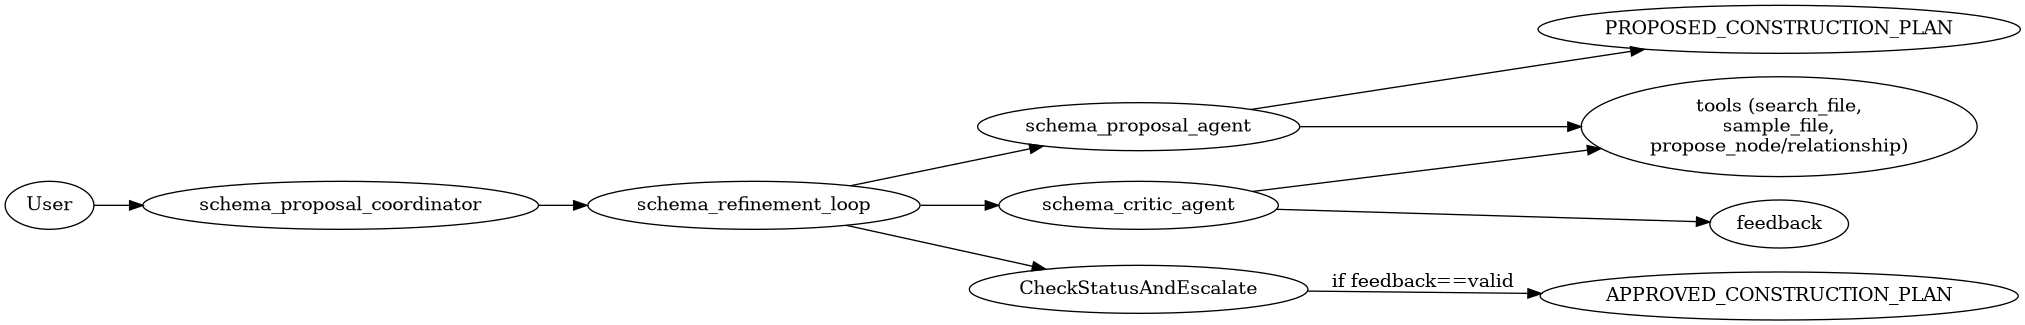

In [5]:
from graphviz import Digraph
from IPython.display import Image, display

dot = Digraph(format='png')
dot.attr(rankdir='LR', fontsize='12')
dot.node('User')
dot.node('Coordinator', 'schema_proposal_coordinator')
dot.node('Loop', 'schema_refinement_loop')
dot.node('Proposal', 'schema_proposal_agent')
dot.node('Critic', 'schema_critic_agent')
dot.node('Stop', 'CheckStatusAndEscalate')
dot.node('Tools', 'tools (search_file,\nsample_file,\npropose_node/relationship)')
dot.node('PROPOSED', 'PROPOSED_CONSTRUCTION_PLAN')
dot.node('FEEDBACK', 'feedback')
dot.node('APPROVED', 'APPROVED_CONSTRUCTION_PLAN')

dot.edge('User', 'Coordinator')
dot.edge('Coordinator', 'Loop')
dot.edge('Loop', 'Proposal')
dot.edge('Loop', 'Critic')
dot.edge('Loop', 'Stop')
dot.edge('Proposal', 'Tools')
dot.edge('Critic', 'Tools')
dot.edge('Proposal', 'PROPOSED')
dot.edge('Critic', 'FEEDBACK')
dot.edge('Stop', 'APPROVED', label='if feedback==valid')

display(Image(dot.pipe(format='png')))